### Import thư viện và chuẩn bị dữ liệu

In [ ]:
#Import thư viện
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
plt.rcParams.update({'figure.figsize':(18,5), 'figure.dpi':120})

In [ ]:
link = 'https://drive.google.com/file/d/1AUYQU7Y3cLTps0nOiFj5LThHTPk69omB/view?usp=sharing'
path =  'https://drive.google.com/uc?export=download&id='+link.split('/')[-2]
df = pd.read_csv(path)

Danh sách các thông số tác động tới price của xe:
1. symboling
2. fuel type
3. aspiration
4. carbody
5. drivewheel
6. enginelocation
7. enginetype
8. cylindernumber
9. curbweight
10. carlength
11. carwidth
12. enginesize
13. boreratio
14. horsepower
15. citympg
16. highwaympg


In [ ]:
#Tạo ra DataFrame mới từ các thông số đã chọn:
df_new = df[['price','symboling', 'fueltype', 'aspiration','carbody', 'drivewheel','enginelocation','enginetype', 'cylindernumber',
             'curbweight', 'carlength','carwidth', 'enginesize', 'boreratio','horsepower',
                    'citympg', 'highwaympg']]

In [ ]:
#Mã hoá data cho bước xây dựng mô hình
#Chọn data object để mã hóa:
selected_columns = df_new.select_dtypes(include=['object'])
for i in selected_columns.columns:
    df_new = pd.get_dummies(df_new, columns=[i], drop_first=False)
df_new.head(3)

,price,symboling,curbweight,carlength,carwidth,enginesize,boreratio,horsepower,citympg,highwaympg,...,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
0,13495,3,2548,168.8,64.1,130,3.47,111,21,27,...,0,0,0,0,0,1,0,0,0,0
1,16500,3,2548,168.8,64.1,130,3.47,111,21,27,...,0,0,0,0,0,1,0,0,0,0
2,16500,1,2823,171.2,65.5,152,2.68,154,19,26,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
#Scale data bằng MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_vars = [ 'curbweight', 'enginesize', 'boreratio', 'horsepower','carlength','carwidth','price']
df_new[num_vars] = scaler.fit_transform(df_new[num_vars])

In [ ]:
y=df_new['price']
X=df_new.drop('price',axis='columns',inplace=False)

In [ ]:
# Sử dụng RFE để tìm ra các thông số ảnh hưởng lớn nhất tới price:
model = LinearRegression()
model.fit(X,y)
rfe = RFE(model)
rfe = rfe.fit(X, y)
list(zip(X.columns,rfe.support_,rfe.ranking_))

[('symboling', False, 19),
 ('curbweight', True, 1),
 ('carlength', True, 1),
 ('carwidth', True, 1),
 ('enginesize', True, 1),
 ('boreratio', False, 12),
 ('horsepower', True, 1),
 ('citympg', False, 11),
 ('highwaympg', False, 17),
 ('fueltype_diesel', False, 10),
 ('fueltype_gas', False, 9),
 ('aspiration_std', False, 16),
 ('aspiration_turbo', False, 20),
 ('carbody_convertible', False, 7),
 ('carbody_hardtop', True, 1),
 ('carbody_hatchback', True, 1),
 ('carbody_sedan', False, 6),
 ('carbody_wagon', False, 18),
 ('drivewheel_4wd', False, 13),
 ('drivewheel_fwd', False, 14),
 ('drivewheel_rwd', False, 4),
 ('enginelocation_front', True, 1),
 ('enginelocation_rear', True, 1),
 ('enginetype_dohc', False, 2),
 ('enginetype_dohcv', True, 1),
 ('enginetype_l', True, 1),
 ('enginetype_ohc', True, 1),
 ('enginetype_ohcf', False, 3),
 ('enginetype_ohcv', True, 1),
 ('enginetype_rotor', False, 5),
 ('cylindernumber_eight', True, 1),
 ('cylindernumber_five', True, 1),
 ('cylindernumber_four

In [ ]:
# Cập nhật những cột được xác định bằng RFE là quan trọng nhất
X = X[X.columns[rfe.support_]]

Text(0.5, 1.0, 'Correlation Heatmap')

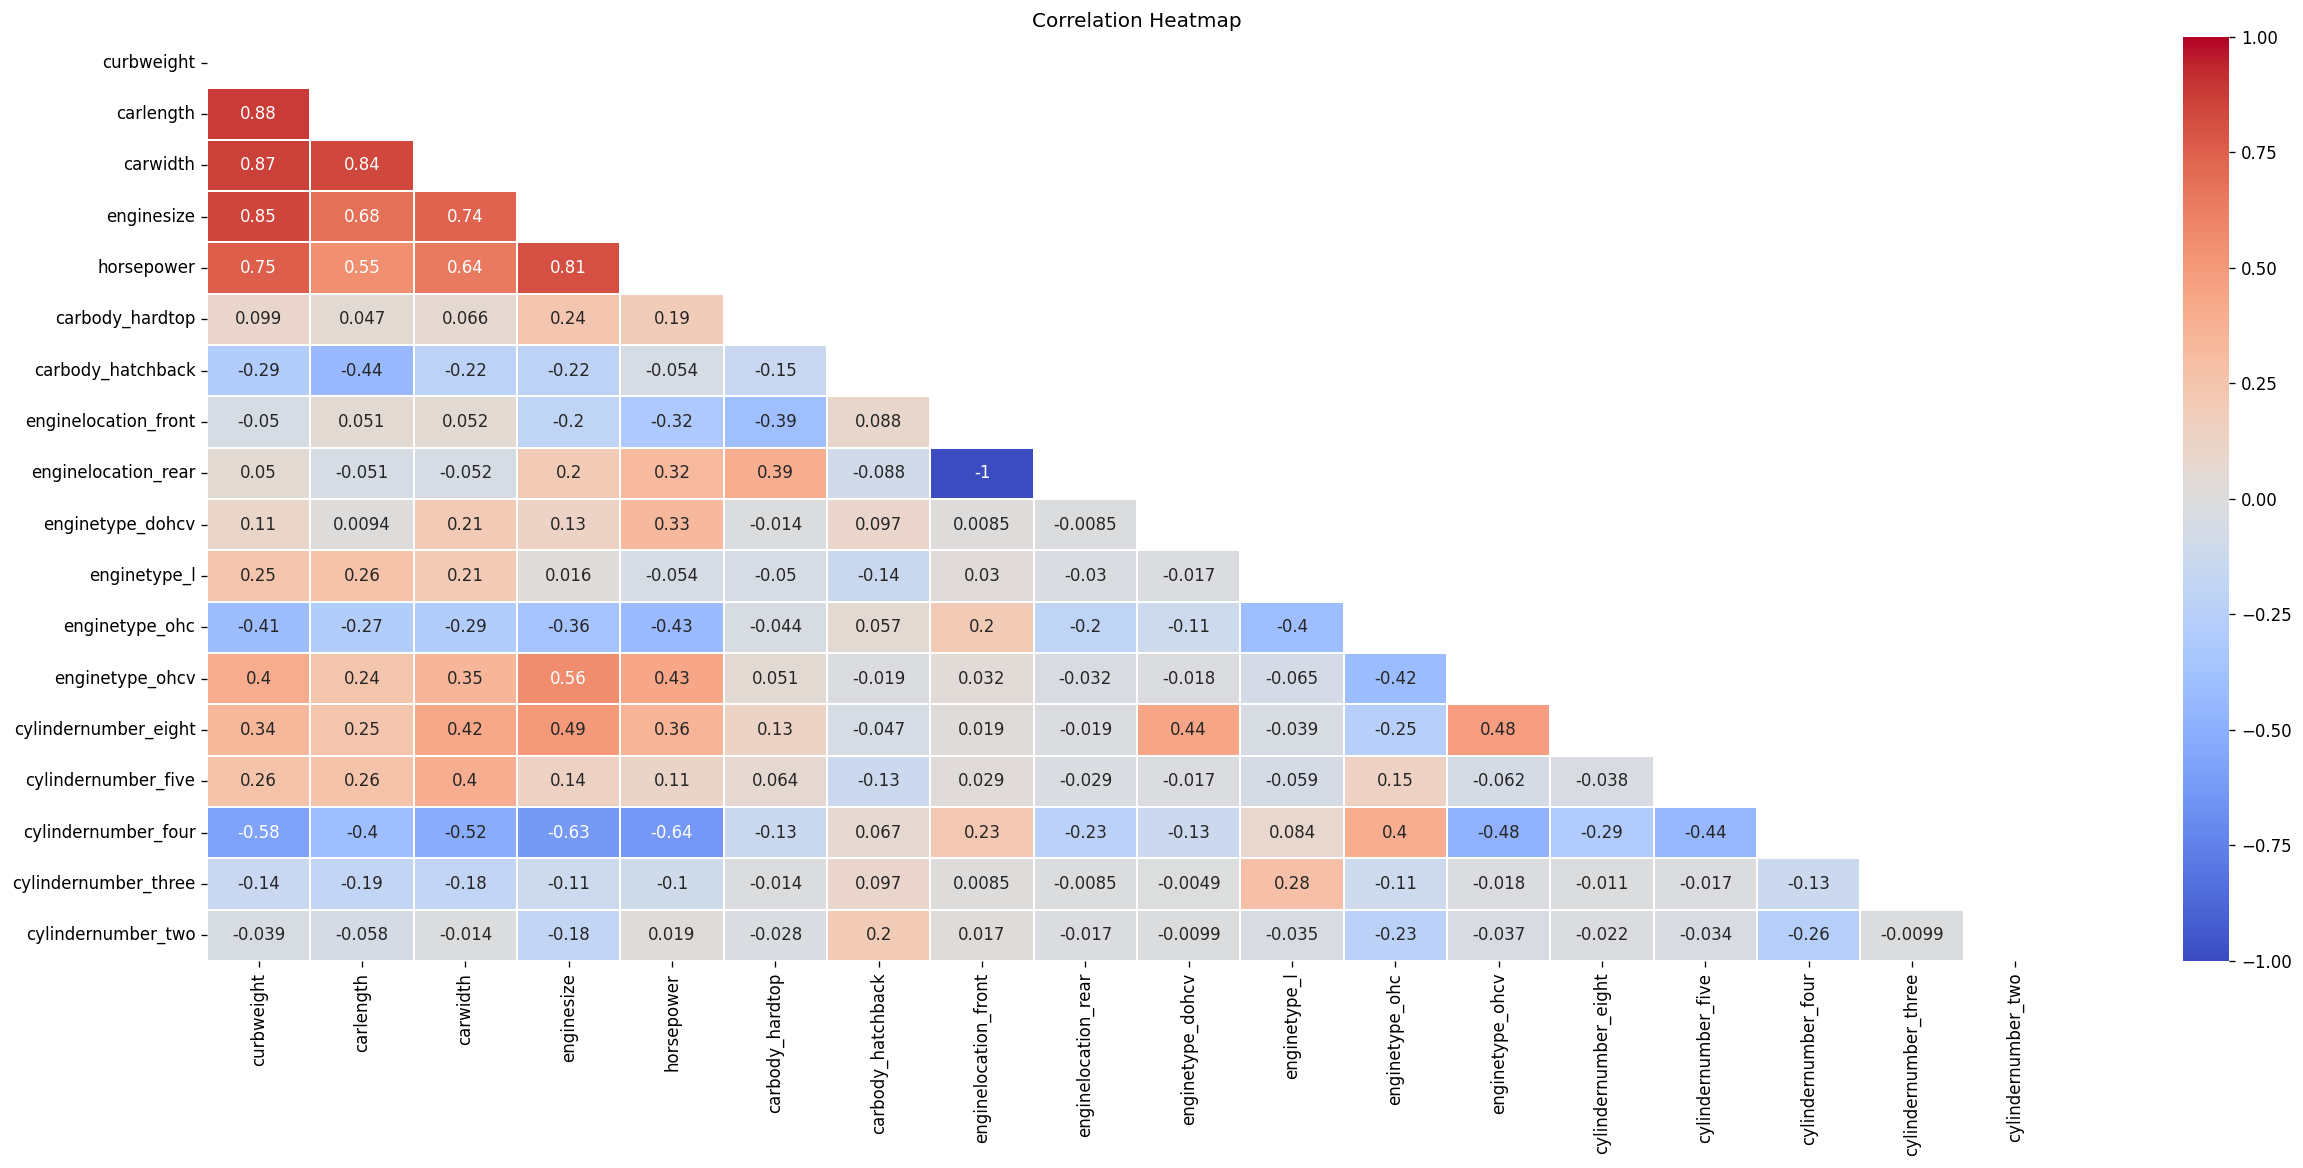

In [ ]:
#Vẽ biểu đồ tương quan để tìm ra những chỉ số tác động tới nhau:
plt.figure(figsize=(25, 10))
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

*   curbweight, carlength, carwidth tương quan cao với nhau nên chỉ cần giữ 1 chỉ số cho mô hình-> Chọn carlength
*   horsepower và enginesize tương quan cao-> Chọn horsepower
*   enginelocation_front và enginelocation_rear tương quan cao-> enginelocation_front



In [ ]:
X = X.drop(["curbweight", "carwidth", "enginesize", "enginelocation_rear"], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=7)

###Sử dụng Kfold để tìm ra mô hình ML có chỉ số tốt nhất

In [ ]:
num_folds = 10
seed = 7
scoring = 'r2'

In [ ]:
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('KNeighborsRegressor', KNeighborsRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [ ]:
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LinearRegression: 0.614146 (0.320401)
KNeighborsRegressor: 0.444524 (0.533524)
DecisionTreeRegressor: 0.686783 (0.311113)
SVR: 0.300229 (0.369633)


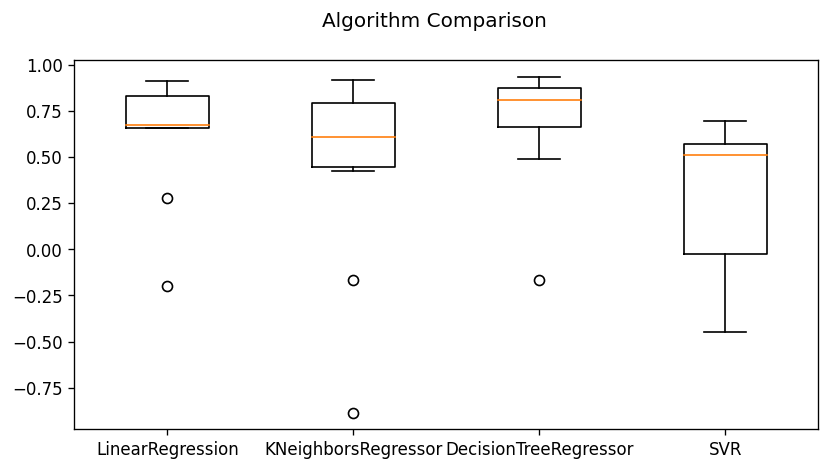

In [ ]:
#Trực quan hóa kết quả tìm được
fig = plt.figure(figsize=(8, 4))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


###Mô hình Linear Regression

In [ ]:
model_lin= LinearRegression()
model_lin.fit(X_train,y_train)
y_pred=model_lin.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("Coefficient of Determination (R^2): {:.2f}".format(r2))

Root Mean Squared Error (RMSE): 0.13
Coefficient of Determination (R^2): 0.23


###Mô hình Support Vector Regression

In [ ]:
param_grid = {'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_search = GridSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("Coefficient of Determination (R^2): {:.2f}".format(r2))

Root Mean Squared Error (RMSE): 0.13
Coefficient of Determination (R^2): 0.14


###Mô hình Decision Tree Regression

In [ ]:
model_lin= DecisionTreeRegressor()
model_lin.fit(X_train,y_train)
y_pred=model_lin.predict(X_test)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("Coefficient of Determination (R^2): {:.2f}".format(r2))

Root Mean Squared Error (RMSE): 0.03
Coefficient of Determination (R^2): 0.95


###Mô hình KNeighbors Regression

In [ ]:
model_lin= KNeighborsRegressor()
model_lin.fit(X_train,y_train)
y_pred=model_lin.predict(X_test)
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("Coefficient of Determination (R^2): {:.2f}".format(r2))

Root Mean Squared Error (RMSE): 0.11
Coefficient of Determination (R^2): 0.38


###->Chọn mô hình Decision Tree Regression để dự báo